In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

In [2]:
# we load two correlated stock
S1 = yf.download(tickers = 'DOCN',start = "2021-07-14",end = "2022-06-01")
S2 = yf.download(tickers = 'AB',start = "2021-07-14",end = "2022-06-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
S1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-14,55.049999,55.049999,50.299999,50.930000,50.930000,468200
2021-07-15,50.540001,50.540001,45.799999,47.450001,47.450001,795700
2021-07-16,48.709999,49.349998,47.820000,48.520000,48.520000,556200
2021-07-19,48.549999,51.820000,47.090000,51.290001,51.290001,816500
2021-07-20,51.299999,51.759998,49.150002,51.580002,51.580002,430000
...,...,...,...,...,...,...
2022-05-24,41.490002,44.250000,39.650002,43.259998,43.259998,3622800
2022-05-25,42.970001,46.270000,42.799999,45.720001,45.720001,2722000
2022-05-26,43.340000,46.869999,43.087002,45.919998,45.919998,3777700


In [4]:
S2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-14,46.009998,46.169998,45.180000,45.740002,42.053215,113900
2021-07-15,45.590000,45.910000,45.180000,45.490002,41.823360,93300
2021-07-16,45.919998,45.919998,45.150002,45.160000,41.519958,137400
2021-07-19,44.650002,44.730000,43.619999,44.349998,40.775249,384100
2021-07-20,44.980000,45.439999,44.509998,45.090000,41.455605,187100
...,...,...,...,...,...,...
2022-05-24,39.770000,40.060001,38.740002,39.630001,39.630001,391300
2022-05-25,39.459999,41.349998,39.419998,41.049999,41.049999,413800
2022-05-26,41.759998,42.580002,41.500000,42.270000,42.270000,493300


In [5]:
# we check for stationary
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False


In [6]:
# we check for cointegration
score, pvalue, _ = coint(S1['Adj Close'], S2['Adj Close'])
print(pvalue)

0.037166313792981846


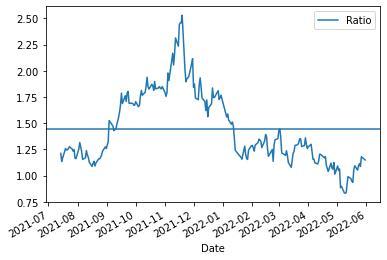

In [7]:
# p < 0.05, it seems to work
# we continue
X1 = S1['Adj Close']
X2 = S2['Adj Close']
ratios = X1 / X2
ratios.plot()
plt.axhline(ratios.mean())
plt.legend(['Ratio'])

plt.show()

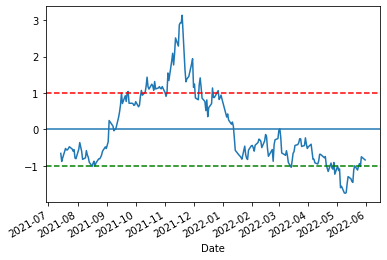

In [8]:
# we normalize the 
# we draw our z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)
zscore(ratios).plot()


plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red',linestyle='dashed')
plt.axhline(-1.0, color='green',linestyle='dashed')

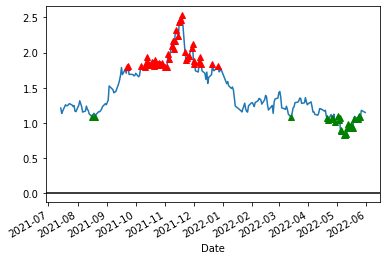

In [9]:
# we use a very simple strategy
# we long as the z-score is below -1.0
# and we short as the z-score is above 1.0
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0


ratios.plot()
plt.axhline(0, color='black')
buy[buy!=0].plot(color='g', linestyle='None', marker='^')
sell[sell!=0].plot(color='r', linestyle='None', marker='^')
plt.show()

<AxesSubplot:xlabel='Date'>

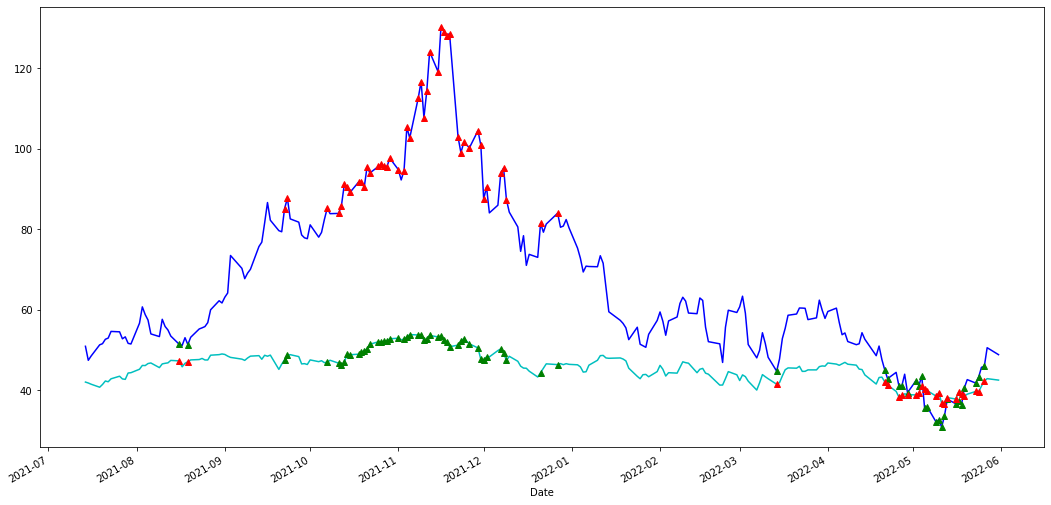

In [10]:
plt.figure(figsize=(18,9))

S1 = S1['Adj Close']
S2 = S2['Adj Close']

S1.plot(color='b')
S2.plot(color='c')

buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[buyR!=0].plot(color='g', linestyle='None', marker='^')
sellR[sellR!=0].plot(color='r', linestyle='None', marker='^')

In [11]:
money = 0
countS1 = 0
countS2 = 0
shares = 1000
zscore = zscore(ratios)
for i in range(len(ratios)):      
    if zscore[i] > 1:
        money += S1[i] - S2[i] * ratios[i]
        countS1 -= 1
        countS2 += ratios[i]

    elif zscore[i] < -1:
        money -= S1[i] - S2[i] * ratios[i]
        countS1 += 1
        countS2 -= ratios[i]

    elif abs(zscore[i]) < 0.5:
        money += countS1*S1[i] + S2[i] * countS2
        countS1 = 0
        countS2 = 0
print(money)


852.1860993031314
